<a href="https://www.kaggle.com/code/ahana09/ps-s3e2?scriptVersionId=116428548" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s3e2/sample_submission.csv
/kaggle/input/playground-series-s3e2/train.csv
/kaggle/input/playground-series-s3e2/test.csv


**Importing libraries and reading inputs**

In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings(action='ignore')
import plotly.express as px
from sklearn.preprocessing import LabelEncoder
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import StratifiedKFold

In [3]:
train = pd.read_csv("/kaggle/input/playground-series-s3e2/train.csv")
test = pd.read_csv("/kaggle/input/playground-series-s3e2/test.csv")
sub =pd.read_csv("/kaggle/input/playground-series-s3e2/sample_submission.csv")

print('The dimession of the train dataset is:', train.shape)
print('The dimession of the test dataset is:', test.shape)

The dimession of the train dataset is: (15304, 12)
The dimession of the test dataset is: (10204, 11)


In [4]:
train.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,0,Male,28.0,0,0,Yes,Private,Urban,79.53,31.1,never smoked,0
1,1,Male,33.0,0,0,Yes,Private,Rural,78.44,23.9,formerly smoked,0
2,2,Female,42.0,0,0,Yes,Private,Rural,103.00,40.3,Unknown,0
3,3,Male,56.0,0,0,Yes,Private,Urban,64.87,28.8,never smoked,0
4,4,Female,24.0,0,0,No,Private,Rural,73.36,28.8,never smoked,0


In [5]:
test.head()

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status
0,15304,Female,57.0,0,0,Yes,Private,Rural,82.54,33.4,Unknown
1,15305,Male,70.0,1,0,Yes,Private,Urban,72.06,28.5,Unknown
2,15306,Female,5.0,0,0,No,children,Urban,103.72,19.5,Unknown
3,15307,Female,56.0,0,0,Yes,Govt_job,Urban,69.24,41.4,smokes
4,15308,Male,32.0,0,0,Yes,Private,Rural,111.15,30.1,smokes


In [6]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15304 entries, 0 to 15303
Data columns (total 12 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   id                 15304 non-null  int64  
 1   gender             15304 non-null  object 
 2   age                15304 non-null  float64
 3   hypertension       15304 non-null  int64  
 4   heart_disease      15304 non-null  int64  
 5   ever_married       15304 non-null  object 
 6   work_type          15304 non-null  object 
 7   Residence_type     15304 non-null  object 
 8   avg_glucose_level  15304 non-null  float64
 9   bmi                15304 non-null  float64
 10  smoking_status     15304 non-null  object 
 11  stroke             15304 non-null  int64  
dtypes: float64(3), int64(4), object(5)
memory usage: 1.4+ MB


 * There are no null values in training dataset

In [7]:
train.describe()

,id,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,15304.000000,15304.000000,15304.000000,15304.000000,15304.000000,15304.000000,15304.000000
mean,7651.500000,41.417708,0.049726,0.023327,89.039853,28.112721,0.041296
std,4418.028595,21.444673,0.217384,0.150946,25.476102,6.722315,0.198981
min,0.000000,0.080000,0.000000,0.000000,55.220000,10.300000,0.000000
25%,3825.750000,26.000000,0.000000,0.000000,74.900000,23.500000,0.000000
50%,7651.500000,43.000000,0.000000,0.000000,85.120000,27.600000,0.000000
75%,11477.250000,57.000000,0.000000,0.000000,96.980000,32.000000,0.000000
max,15303.000000,82.000000,1.000000,1.000000,267.600000,80.100000,1.000000


**EDA**

In [8]:
train1=train.copy()
train1=train.drop('id',axis=1)
train1.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,28.0,0,0,Yes,Private,Urban,79.53,31.1,never smoked,0
1,Male,33.0,0,0,Yes,Private,Rural,78.44,23.9,formerly smoked,0
2,Female,42.0,0,0,Yes,Private,Rural,103.00,40.3,Unknown,0
3,Male,56.0,0,0,Yes,Private,Urban,64.87,28.8,never smoked,0
4,Female,24.0,0,0,No,Private,Rural,73.36,28.8,never smoked,0


In [9]:
def list_maker(my_list,datatype):
  '''
  custom function to create two groups for numerical features and categorical features
  '''
  train_col=list(train1.columns)
  for i in train_col:
    if type(train1[i][0])==datatype :
      my_list.append(i)


numerical_feat=list()
object_feat=list()

list_maker(object_feat,str)

list_maker(numerical_feat,np.int64)
list_maker(numerical_feat,np.float64)

In [10]:
print(numerical_feat)
print(object_feat)

['hypertension', 'heart_disease', 'stroke', 'age', 'avg_glucose_level', 'bmi']
['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']


In [11]:
def UVA_numeric(data, var_group):
  '''
  Univariate Analysis of numeric columns
  takes a group of variables(Integer and Float)
  and plot/print all the descriptives and properties along with KDE
  runs a loop: calculate all the descriptives of i(th) variable and plot/print it.
  '''

  size = len(var_group)
  plt.figure(figsize=(7*size, 3), dpi=120)

  # looping over each feature
  for j ,i in enumerate(var_group):

    # calculating of descriptives of variables
    minm = data[i].min()
    maxm = data[i].max()
    ran = maxm - minm
    mean = data[i].mean()
    median = data[i].median()
    st_dev = data[i].std()
    skew = data[i].skew()
    kurt = data[i].kurtosis()
    
    # calculation of points of inflection
    points = mean-st_dev, mean+st_dev

    #plotting the variables with every information
    plt.subplot(1, size, j+1)
    sns.kdeplot(data[i], shade=True)
    sns.scatterplot([minm, maxm], [0,0], color='blue', label='max/min')
    sns.scatterplot([mean], [0], color='green', label='mean')
    sns.scatterplot([median], [0], color='orange', label='median')
    sns.scatterplot(points, [0,0], color='pink', label='points of inflection')
    plt.xlabel(f'{i}')
    plt.ylabel('Density')
    plt.title(f'Point of Inflection={(round(points[0],2), round(points[1],2))}; range={round(ran,2)};\nskewness={round(skew,2)}; kurtosis={round(kurt,2)}; \nmean={round(mean,2)}; median={round(median,2)}')

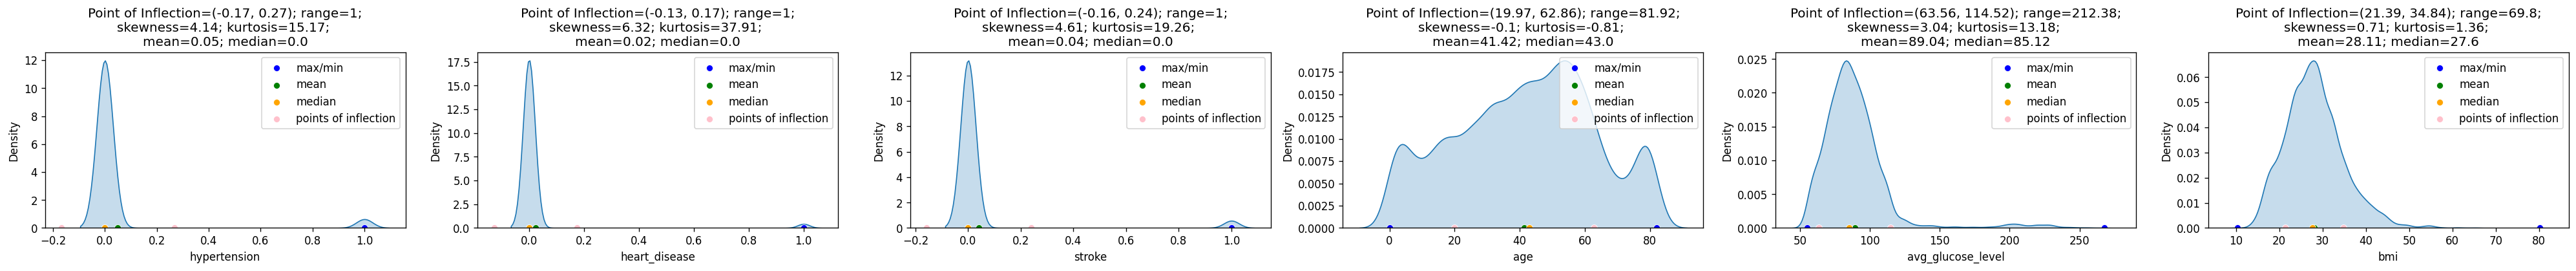

In [12]:
UVA_numeric(train1,numerical_feat)

In [13]:
# Custom Function for easy visualization and analysis of categorical values
def UVA_category(data, var_group):
  '''
  Univariate Analysis of Categorical Columns
  Takes a list of category and a DataFrame
  Prints/plots all value_counts and barplot
  '''
  #setting figsize
  size = len(var_group)
  plt.figure(figsize=(9*size, 5), dpi=120)

  for j, i in enumerate(var_group):
    #for counting the unique values
    norm_count = data[i].value_counts(normalize=True)
    n_uni = data[i].nunique()

    #plotting the variable with ebery information 
    plt.subplot(1, size, j+1)
    sns.barplot(norm_count, norm_count.index, order=norm_count.index)
    plt.xlabel(f'Fraction/percent', fontsize=20)
    plt.ylabel(f'{i}', fontsize=10)
    plt.title(f'n_uniques={n_uni}\nValue_counts={norm_count}')

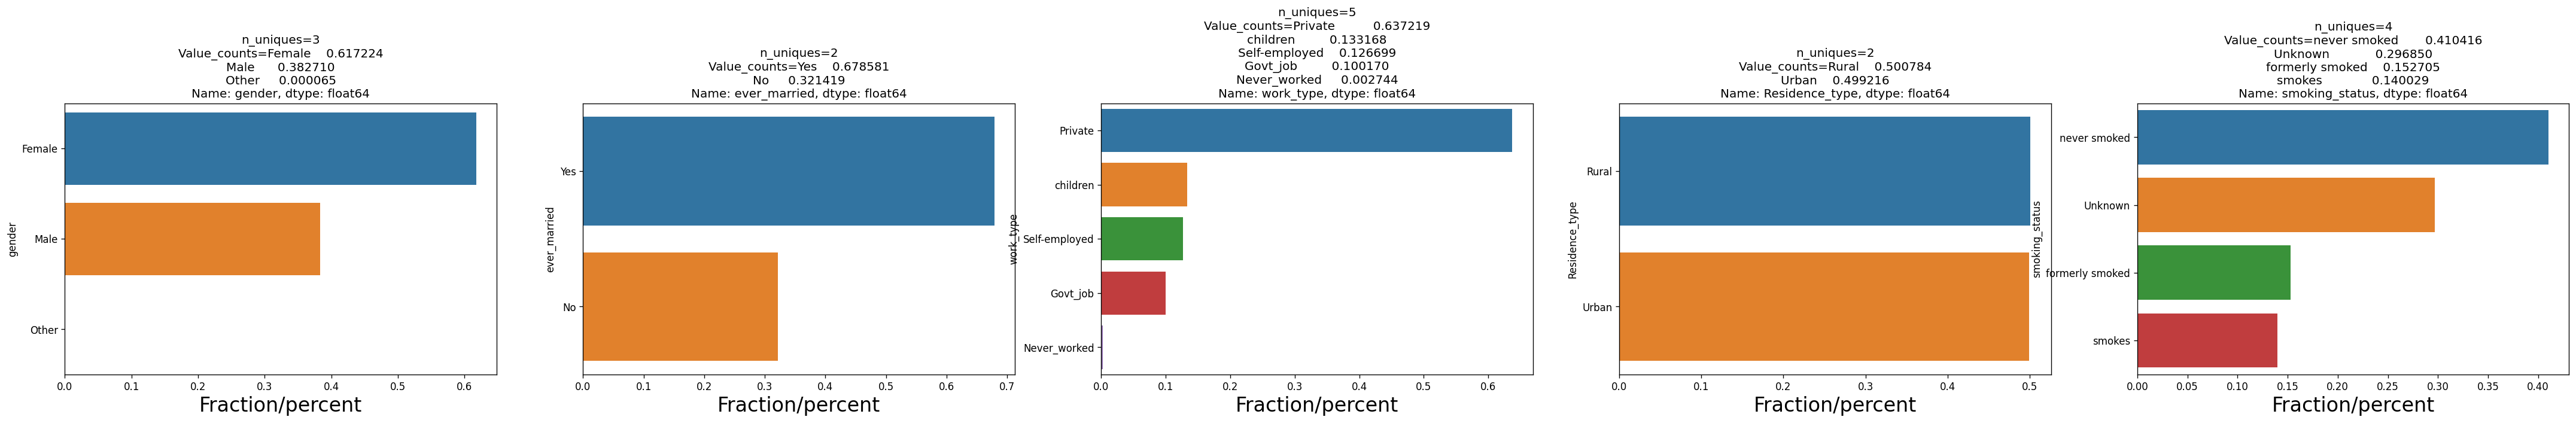

In [14]:
UVA_category(train1,object_feat)

<AxesSubplot:>

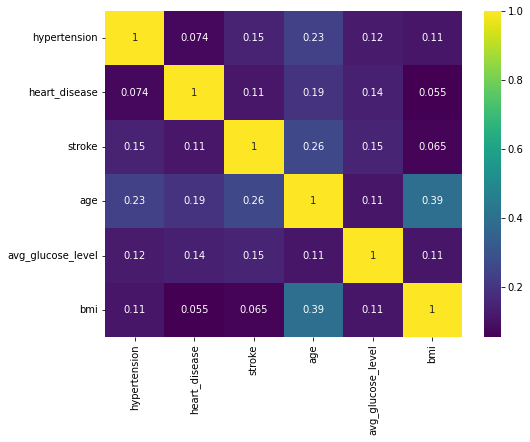

In [15]:
numerical_df = train1[numerical_feat]
plt.figure(figsize=(8,6))
sns.heatmap(numerical_df.corr(), annot=True, cmap='viridis')

* Age and stroke has strong relation
* Age and hypertension has strong relation
* Age and bmi has strong relation

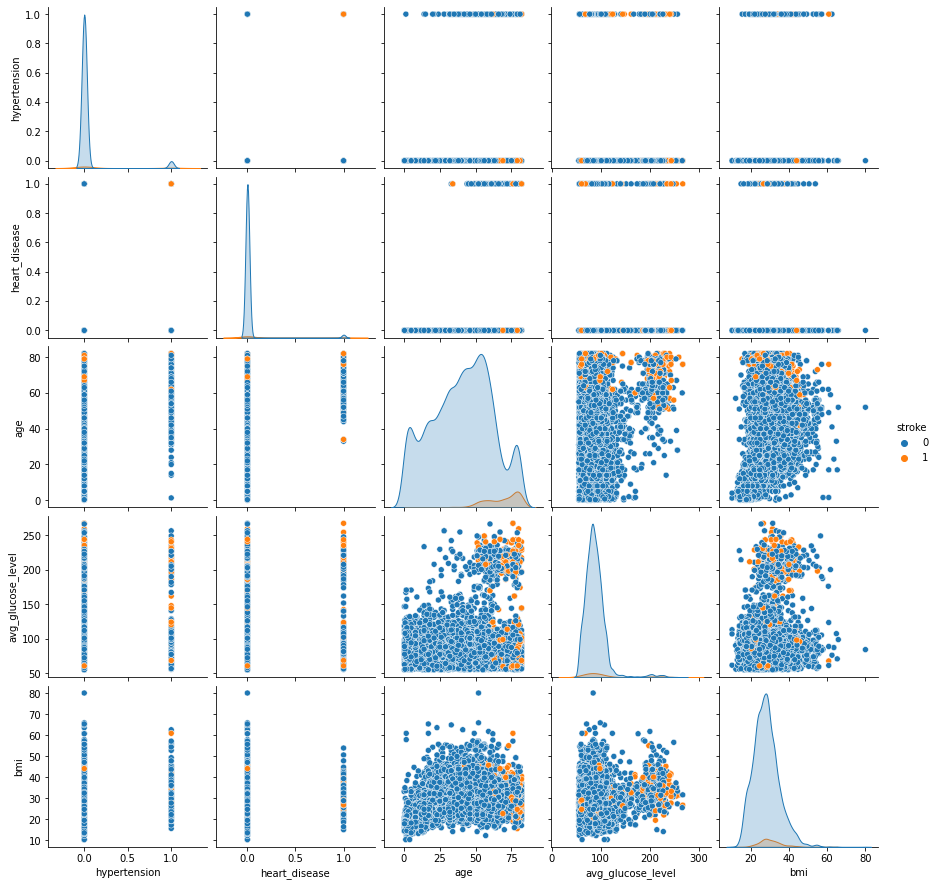

In [16]:
sns.pairplot(numerical_df.iloc[:,:], hue="stroke")

In [17]:
fig = px.scatter_3d(train1, x = "age", y="bmi", z="hypertension", color="stroke", title="Visualization of the mutual relationship among age, bmi,hypertension")
fig.show()

**Train Model**

In [18]:
le = LabelEncoder()
for i in object_feat:
    train[i] = le.fit_transform(train[i])
    test[i] = le.transform(test[i])

In [19]:
X = train.drop('stroke', axis=1)
y = train['stroke']

In [20]:
skf = StratifiedKFold(n_splits=5, random_state=1, shuffle=True)

for fold, (train_idx, test_idx) in enumerate(skf.split(X, y)):
    print(f"Fold: {fold}")
    X_train, X_test = X.iloc[train_idx], X.iloc[test_idx]
    y_train, y_test = y.iloc[train_idx], y.iloc[test_idx]

    model = XGBClassifier(n_estimators=2023,learning_rate=0.02)
   
    model.fit(X_train, y_train,
              eval_set=[(X_test, y_test)],
                early_stopping_rounds=100,
                verbose=False)
    y_pred = model.predict_proba(X_test)[:,1]
    roc_auc = roc_auc_score(y_test, y_pred)
    print(f" roc_auc score: {roc_auc}")
    print("-"*50)  

Fold: 0
 roc_auc score: 0.9061328790459966
--------------------------------------------------
Fold: 1
 roc_auc score: 0.8684608312376625
--------------------------------------------------
Fold: 2
 roc_auc score: 0.8881132956539941
--------------------------------------------------
Fold: 3
 roc_auc score: 0.8667187307108084
--------------------------------------------------
Fold: 4
 roc_auc score: 0.8850274829313685
--------------------------------------------------


In [21]:
sub['stroke'] = model.predict_proba(test)[:,1]
sub.head()

,id,stroke
0,15304,0.028193
1,15305,0.459503
2,15306,0.003796
3,15307,0.080252
4,15308,0.016079


In [22]:
sub.to_csv('submission.csv',index=False)